# Movie Box Office Sales Classifer

In [1]:
#load packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn import *
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
from itertools import cycle
from scipy import interp

import os

/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/home/ubuntu/anaconda3/lib/python3.5/site-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarnin

In [2]:
#define helper functions for modeling
def get_predictions(model, X_test, X_train, y_train):
    '''helper function to get predictions.
       parameters:
       model: trained model
       X_test: test set features
       X_train: train set features
       y_train; train set target'''
    model.fit(X_train, y_train)
    hard_predicts = model.predict(X_test)
    proba_predicts = model.predict_proba(X_test)
    
    return model, hard_predicts, proba_predicts

    
def get_cv_log(model, X, y, n):
    '''gives cross-validated log loss core. n splits
    parameters:
    model = model used
    X = features
    y = target
    n = number of folds'''
    cv = model_selection.StratifiedKFold(n_splits=n)
    log_loss_list = []

    for train, test in cv.split(X,y):
        _, model_pred, model_pred_proba = get_predictions(model, X.iloc[test,:], X.iloc[train,:], y[train])
        log_loss_list.append(metrics.log_loss(y[test], model_pred_proba))
        
    return np.mean(log_loss_list)

def plot_cm(y_test, y_pred):
    '''helper function to plot confusion matrix.
       parameters:
       y_test: test set
       y_pred: hard predictions'''
    cm = confusion_matrix(y_test, y_pred, binary=False)
    fig, ax = plot_confusion_matrix(cm)
    fig.set_size_inches(7,7)
    ax.set_title('Model\'s Confusion Matrix')
    ax.set_xticks([x for x in range(1,10)]);
    ax.set_xticklabels(range(2, 10));
    ax.set_yticks([x for x in range(1,10)]);
    ax.set_yticklabels(range(2, 10));

def plot_overfit(metric, X, y, model_obj, param_ranges, param_static=None): 
    '''helper function to plot performance of model accross different parameters.
    '''
    
    if metric == 'log_loss':
        cv = model_selection.StratifiedKFold(n_splits=2)
        
        for parameter,parameter_range in param_ranges.items():
            avg_train_score = [] 
            avg_test_score = []
            std_train_score = [] 
            std_test_score = []

            for param_val in parameter_range:
                #print watcher to command line
                string_to_echo = 'checking parameter value: ' + str(param_val)
                cmd="echo "+string_to_echo
                os.system(cmd)
                
                #set parameters of model to be tested
                param = {parameter:param_val}
                if param_static:
                    param.update(param_static)


                model = model_obj(**param)
                
                #get the 3-fold cross validation score 3 times for each train and test. average them and get the stdev.
                train_scores = []
                test_scores = []
                for i in range(2):
                    test_log_loss_list = []
                    train_log_loss_list = []
                    for train, test in cv.split(X,y):
                        model.fit(X.iloc[train,:], y[train])
                        
                        test_hard_predicts = model.predict(X.iloc[test,:])
                        test_proba_predicts = model.predict_proba(X.iloc[test,:]) 
                        
                        train_hard_predicts = model.predict(X.iloc[train,:])
                        train_proba_predicts = model.predict_proba(X.iloc[train,:]) 
                        
                        test_log_loss_list.append(metrics.log_loss(y[test], test_proba_predicts))
                        train_log_loss_list.append(metrics.log_loss(y[train], train_proba_predicts))
                    
                    train_scores.append(np.mean(train_log_loss_list))
                    test_scores.append(np.mean(test_log_loss_list))
                    #string_to_write = 'param_val: ' + str(param_val) + ' log loss: ' + str(np.mean(test_log_loss_list))
                    #f.write(string_to_write)
                    
                avg_train_score.append(np.mean(train_scores))
                avg_test_score.append(np.mean(test_scores))

                std_train_score.append(np.std(train_scores))
                std_test_score.append(np.std(test_scores))
            
            #plot the train and test log loss scores
            fig,ax = plt.subplots(figsize=(10,4))
            ax.errorbar(parameter_range,avg_train_score,yerr=std_train_score,label='training score')
            ax.errorbar(parameter_range,avg_test_score,yerr=std_test_score,label='testing score')

            ax.set_xlabel(parameter)
            ax.set_ylabel('log loss')
            ax.legend(loc=0)
            
def modify_prod_method(value):
    '''helper function to reduce sub-categories of poduction method into 3.
    '''
    
    if value == 'Live Action' or value == 'Animation/Live Action':
        return value
    elif value == 'Digital Animation' or value == 'Hand Animation' or value == 'Stop-Motion Animation':
        return 'Animation'
    
def get_num_competitors(row, df_competition):
    '''helper function to get number of competitors in the genre for the same production year.
    '''
    return df_competition.loc[(df_competition['production_year'] == row['production_year']) & (df_competition['genre'] == row['genre'])][0].values[0]

def get_num_competitors_total(row, df_competition):
    '''helper function to get number of total competitors for the same production year.
    '''
    return df_competition.loc[df_competition['production_year'] == row['production_year']][0].values[0]

def rating_to_ranked_order(value):
    '''helper function to convert rating to a ranked list rather than one-hot encoding.
    '''
    return movie_board_rating_ranked_list.index(value) + 1

def genre_to_ranked_order(value):
    '''helper function to convert genre to a ranked list rather than one-hot encoding.
    '''
    return genre_ranked_list.index(value) + 1

def prepare_data(df_scoring):
    '''helper function to convert genre to a ranked list rather than one-hot encoding.
    '''
    df_scoring.drop(['id', 'name', 'display_name'], axis=1, inplace=True)

    
    #collapse production method
    df_scoring['production_method'] = df_scoring['production_method'].map(modify_prod_method)
    
    #competition under the same genre
    df_competition = df_scoring.groupby(['production_year', 'genre']).size().reset_index()
    df_scoring['competition_genre'] = df_scoring.apply(get_num_competitors, args=(df_competition,), axis=1)

    #competition of all movies produced in the same year
    df_competition = df_scoring.groupby('production_year').size().reset_index()
    df_scoring['competition_total'] = df_scoring.apply(get_num_competitors_total, args=(df_competition,), axis=1)

    
    df_scoring['movie_board_rating_ranked'] = df_scoring['movie_board_rating_display_name'].map(rating_to_ranked_order)
    df_scoring.drop('movie_board_rating_display_name', axis=1, inplace=True)
    
    df_scoring['genre_ranked'] = df_scoring['genre'].map(genre_to_ranked_order)
    df_scoring.drop('genre', axis=1, inplace=True)
    
    df_scoring.drop(['production_year'], axis=1, inplace=True)
    
    for column in df_scoring.columns:
        if column == 'Category':
            continue
        elif df_scoring[column].dtypes != 'int64':
            dummies = pd.get_dummies(df_scoring[column])
            df_scoring = pd.concat([df_scoring, dummies], axis=1)
    
    df_scoring.drop(['French', 'Indonesian/Balinese', 'Spanish', 'Animation/Live Action', 'Special Engagement', 'creative_type', 'source', 'production_method', 'language', 'movie_release_pattern_display_name'], axis =1, inplace=True)
    
    for col in set(X_test_improvement.columns.tolist()) - set(df_scoring.columns.tolist()):
        df_scoring[col] = np.zeros(df_scoring.shape[0])
    return df_scoring

## Step 1: Load & Inspect Data

In [3]:
df_orig = pd.read_excel('/home/ubuntu/challenge_quantiphi/training_sheet.xlsx')
df = pd.read_excel('/home/ubuntu/challenge_quantiphi/training_sheet.xlsx')
df.head()

,id,name,display_name,production_year,movie_sequel,creative_type,source,production_method,genre,language,board_rating_reason,movie_board_rating_display_name,movie_release_pattern_display_name,total,Category
0,7950115,Avatar,Avatar,2009,0,Science Fiction,Original Screenplay,Animation/Live Action,Action,English,"For intense epic battle sequences and warfare,...",PG-13,Wide,2784,9
1,50950115,Harry Potter and the Deathly Hallows: Part II,Harry Potter and the Deathly Hallows: Part II,2011,1,Fantasy,Based on Fiction Book/Short Story,Animation/Live Action,Adventure,English,for some sequences of intense action violence ...,PG-13,Wide,1328,9
2,119870115,Transformers 3,Transformers: Dark of the Moon,2011,1,Science Fiction,Based on TV,Animation/Live Action,Action,English,for intense prolonged sequences of sci-fi acti...,PG-13,Wide,1124,9
3,119590115,Toy Story 3,Toy Story 3,2010,1,Kids Fiction,Original Screenplay,Digital Animation,Adventure,English,General,G,Wide,1064,9
4,91700115,Pirates of the Caribbean 4,Pirates of the Caribbean: On Stranger Tides,2011,1,Fantasy,Based on Theme Park Ride,Live Action,Adventure,English,for intense sequences of action/adventure viol...,PG-13,Wide,1044,9


* explore features

In [4]:
#check datatypes of each feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1196 entries, 0 to 1195
Data columns (total 15 columns):
id                                    1196 non-null int64
name                                  1196 non-null object
display_name                          1196 non-null object
production_year                       1196 non-null int64
movie_sequel                          1196 non-null int64
creative_type                         1196 non-null object
source                                1196 non-null object
production_method                     1196 non-null object
genre                                 1196 non-null object
language                              1196 non-null object
board_rating_reason                   1196 non-null object
movie_board_rating_display_name       1196 non-null object
movie_release_pattern_display_name    1196 non-null object
total                                 1196 non-null int64
Category                              1196 non-null int64
dtypes: int64

* let's drop independent variables that are not suitable for predictions

In [5]:
df.drop(['id', 'name', 'display_name', 'board_rating_reason'], axis=1, inplace=True)

* let's drop production year. not a useful feature since it model may learn on unneccesary information and have to extrapolate for future productions. although, we might use this feature later on to create a feature to indicate how many movies were produced in the specific year. 

In [6]:
df.drop(['production_year'], axis=1, inplace=True)

* let's drop total. target feature category was dervied from total so let's not use this for predictions.

In [7]:
df.drop(['total'], axis=1, inplace=True)

* let's look at distribution of target variable

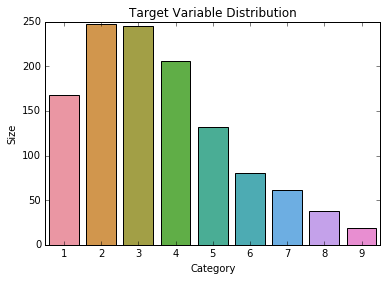

In [8]:
sns.barplot(x='Category', y=0, data=df.groupby('Category').size().reset_index().sort_values(0, ascending=True))
plt.ylabel('Size')
plt.title('Target Variable Distribution');

* let's look at distribution of each independent variable.. we notice that some features have a skewed distribution. for now, let's continue with one-hot encoding and consider collapsing categories later on and see if this improves model performance compared to baseline scores.

CATEGORICAL FEATURE: creative_type = 9 subcategories
CATEGORICAL FEATURE: source = 16 subcategories
CATEGORICAL FEATURE: production_method = 6 subcategories
CATEGORICAL FEATURE: genre = 13 subcategories
CATEGORICAL FEATURE: language = 16 subcategories
CATEGORICAL FEATURE: movie_board_rating_display_name = 6 subcategories
CATEGORICAL FEATURE: movie_release_pattern_display_name = 7 subcategories


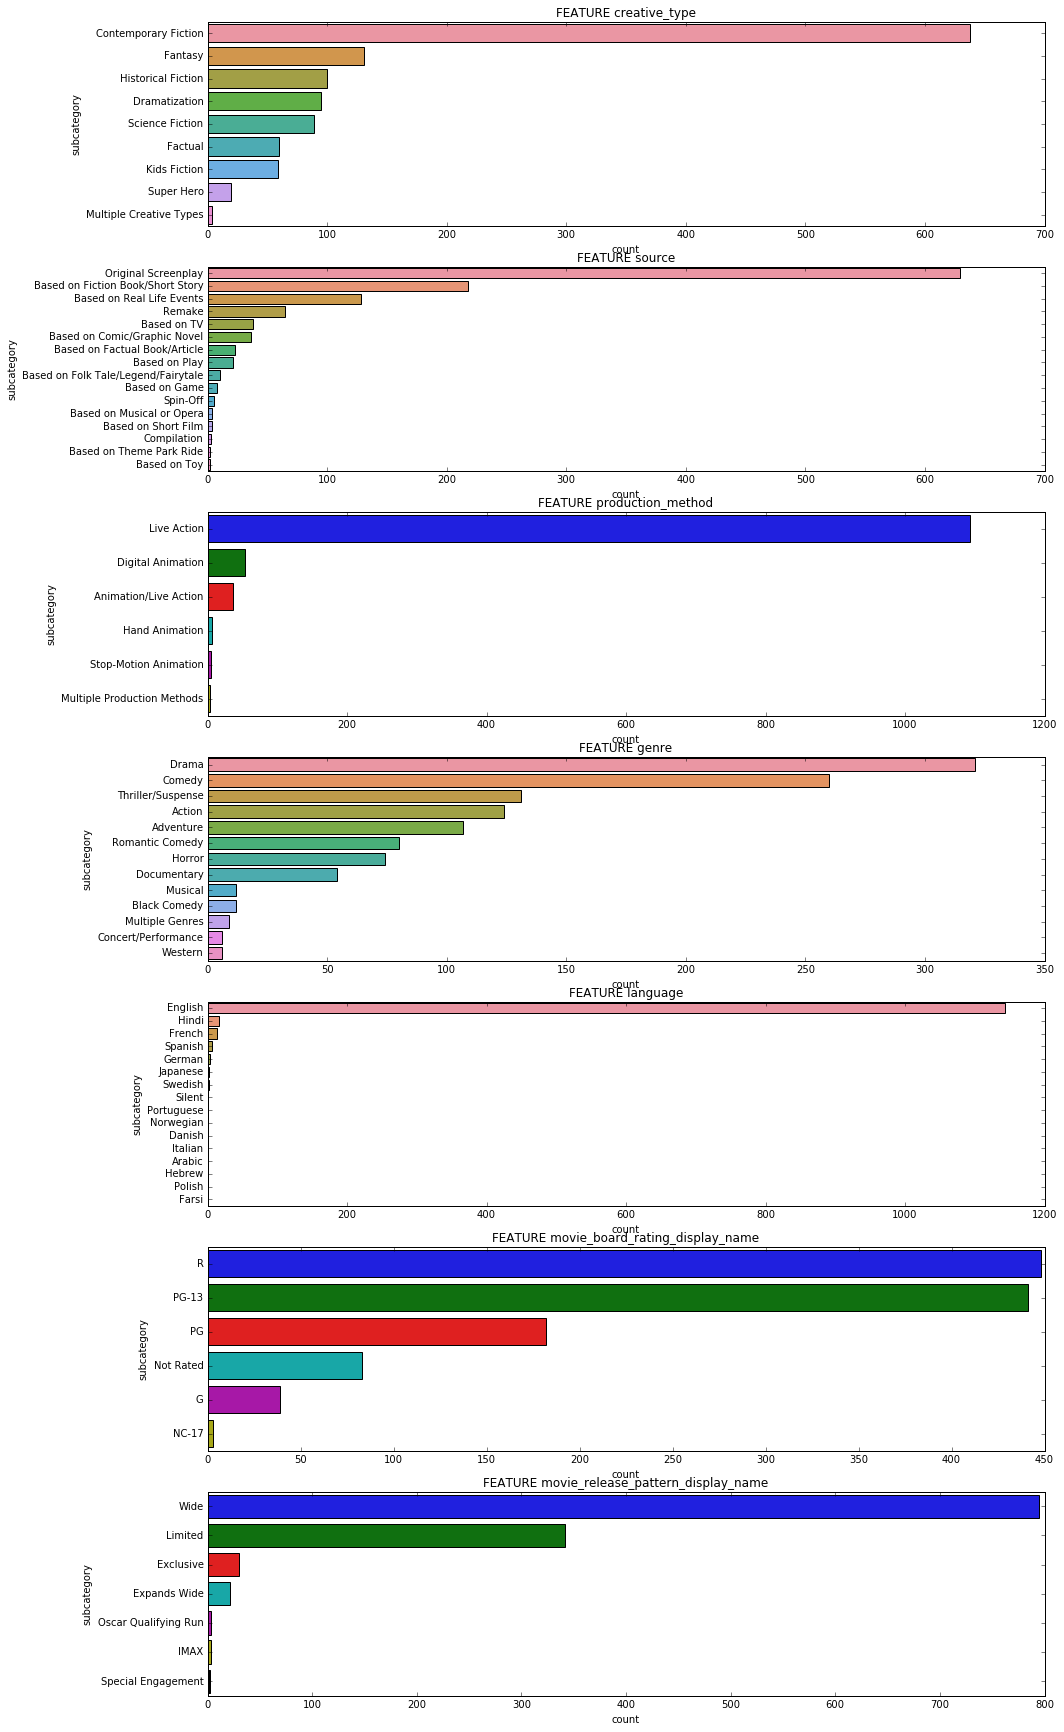

In [9]:
fig , ax = plt.subplots(7, 1, figsize=(15,30))
i = 0
for column in df.columns:
    if df[column].dtypes != 'int64':
        print ('CATEGORICAL FEATURE:', column, '=',  df[column].unique().size, 'subcategories')
        sns.barplot(ax = ax[i], y='index', x=column, data=df[column].value_counts().reset_index())
        title = 'FEATURE ' + column 
        ax[i].set_title(title)
        ax[i].set_xlabel('count')
        ax[i].set_ylabel('subcategory')
        i+=1

## Step 2: Prepare Data for Training

* let's create a dataframe for training "df_main" with categorical variables treated with one-hot encoding. for each category drop one sub-category to avoid co-linearity

In [10]:
df_main = pd.DataFrame.copy(df.drop(['creative_type', 'source', 'production_method', 'genre', 'language', 'movie_board_rating_display_name', 'movie_release_pattern_display_name'], axis =1))
for column in df.columns:
    if column == 'Category':
        continue
    elif df[column].dtypes != 'int64':
        dummies = pd.get_dummies(df[column])
        df_main = pd.concat([df_main, dummies], axis=1)

df_main.drop(['Special Engagement', 'NC-17', 'Arabic', 'Western', 'Multiple Production Methods', 'Based on Toy', 'Multiple Creative Types'], axis=1, inplace=True)
df_main.head()

,movie_sequel,Category,Contemporary Fiction,Dramatization,Factual,Fantasy,Historical Fiction,Kids Fiction,Science Fiction,Super Hero,...,Not Rated,PG,PG-13,R,Exclusive,Expands Wide,IMAX,Limited,Oscar Qualifying Run,Wide
0,0,9,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
1,1,9,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,1,9,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
3,1,9,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,9,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


* split into depenedent (target) and independent variables (features), split into 70% train and 30% test

In [11]:
y_main = df_main['Category']
X_main = df_main.drop('Category', axis=1)

# Split into training and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_main, y_main, test_size=.3)

print ('training size', X_train.shape[0])
print ('test size', X_test.shape[0])

training size 837
test size 359


## Step 3: Train Baseline Models (Knn, Decision Tree, Random Forest, Gradient Boosted)  

NOTE: Making use of multi-class log-loss as main metric for evaluation. A lower log-loss score results in a better accuracy of the model. Using this metric rathern than accuracy score because of imbalanced classes as seen in data investigation section.

NOTE: For paramter tuning, let's make use of log-loss to maximize quality of model's prediction's probability. later on, we may find best parameters using different metric depending on certain use cases later on.

#### Model 1: KNearest Neighbors Classifier  
(let's see if we can make predictions based on similarity amongst movie's characteristics) 

* find best parameters nearest neighbors

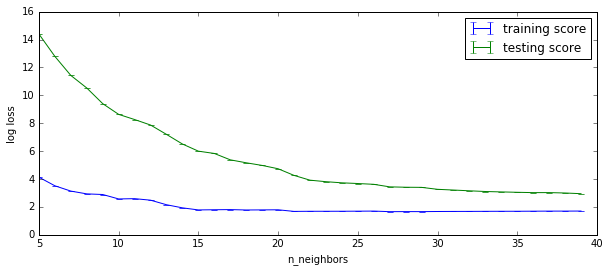

In [12]:
plot_overfit('log_loss', X_main, y_main, neighbors.KNeighborsClassifier, {'n_neighbors':range(5,40)})

* evaluate log-loss score  

In [13]:
model_knn = neighbors.KNeighborsClassifier(n_neighbors=30)

#get score
knn_score = get_cv_log(model_knn, X_main, y_main, 6)
print ('cross-validated log loss score: ', knn_score)

#get predictions
_, model_knn_pred, model_knn_pred_proba = get_predictions(model_knn, X_test, X_train, y_train)

#show confusion matrix
#plot_cm(y_test, model_knn_pred)

cross-validated log loss score:  3.22393562687


#### Model 2: Decision Tree Classifier  
(let's see performance of a single decision tree as a baseline for comparison against RF and GB
Trees. RF and GB should perform better when all parameters are tuned.)

* find best parameters for decision tree

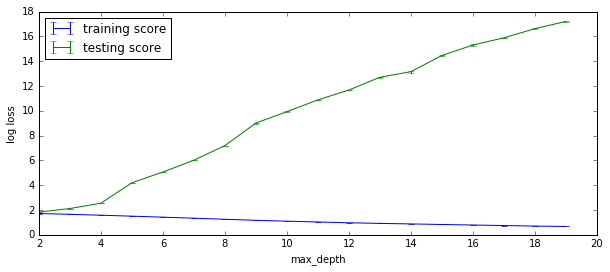

In [14]:
plot_overfit('log_loss', X_main, y_main, tree.DecisionTreeClassifier, {'max_depth':range(2,20)})

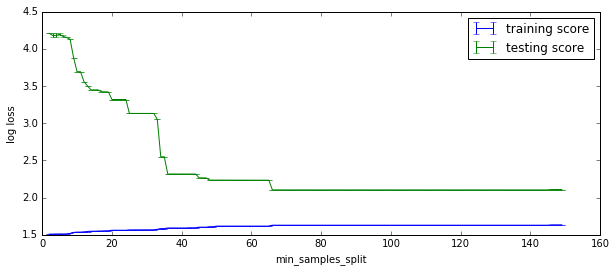

In [15]:
plot_overfit('log_loss', X_main, y_main, tree.DecisionTreeClassifier, {'min_samples_split':range(2,150,1)}, param_static={'max_depth':5})

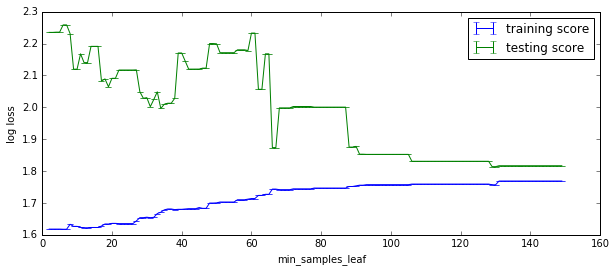

In [16]:
plot_overfit('log_loss', X_main, y_main, tree.DecisionTreeClassifier, {'min_samples_leaf':range(2,150,1)}, param_static={'max_depth':5, 'min_samples_split':63})

* evaluate log-loss score

In [17]:
model_tree = tree.DecisionTreeClassifier(max_depth=5, min_samples_split=63, min_samples_leaf=120)

#get score
tree_score = get_cv_log(model_tree, X_main, y_main, 6)
print ('cross-validated log loss score: ', tree_score)

#get predictions
_, model_tree_pred, model_tree_pred_proba = get_predictions(model_tree, X_test, X_train, y_train)

cross-validated log loss score:  1.82000755861


#### Model 3: Random Forest Classifier  
(let's see performance of a bunch of decision trees. theoretically combining a bunch of "weak" learners to generate averaged  predictions to form a "strong" learner should result in better predictive performance) 

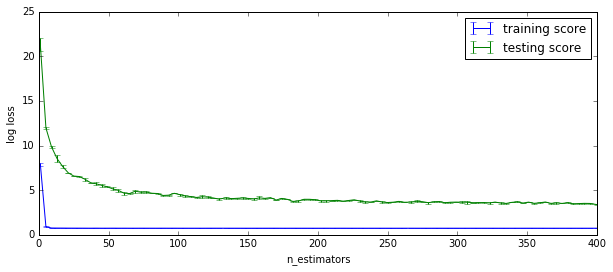

In [18]:
plot_overfit('log_loss', X_main, y_main, ensemble.RandomForestClassifier, {'n_estimators':np.linspace(1,400,100, dtype=int)})

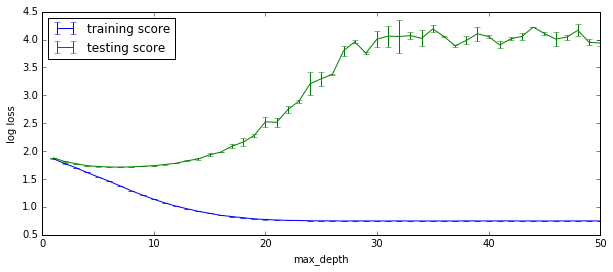

In [19]:
plot_overfit('log_loss', X_main, y_main, ensemble.RandomForestClassifier, {'max_depth':np.linspace(1,50,50, dtype=int)}, param_static={'n_estimators':150})

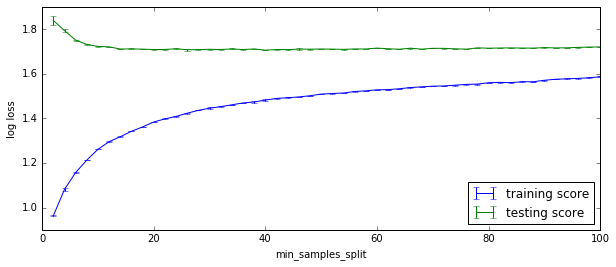

In [20]:
plot_overfit('log_loss', X_main, y_main, ensemble.RandomForestClassifier, {'min_samples_split':np.linspace(2,100,50, dtype=int)}, param_static={'n_estimators':150, 'max_depth':13})

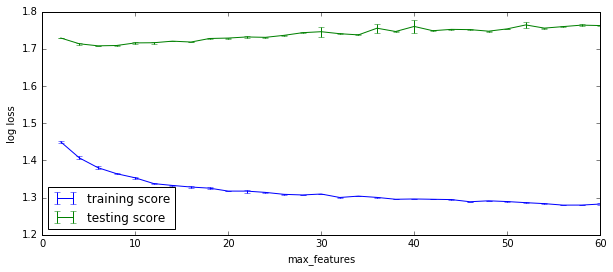

In [21]:
plot_overfit('log_loss', X_main, y_main, ensemble.RandomForestClassifier, {'max_features':np.linspace(2,60,30, dtype=int)}, param_static={'n_estimators':150, 'max_depth':13, 'min_samples_split':18})

* evaluate log loss score

In [22]:
model_rf = ensemble.RandomForestClassifier(n_estimators=150, max_depth=13, min_samples_split=18, max_features=25)

#get score
rf_score = get_cv_log(model_rf, X_main, y_main, 6)
print ('cross-validated log loss score: ', rf_score)

#get predictions
_, model_rf_pred, model_rf_pred_proba = get_predictions(model_rf, X_test, X_train, y_train)

cross-validated log loss score:  1.71636962265


#### Model 4: Gradient Boosted Tree
(let's see performance of a bunch of decision trees. theoretically combining a bunch of "weak" learners to generate averaged  predictions to form a "strong" learner) 

* find best parameters

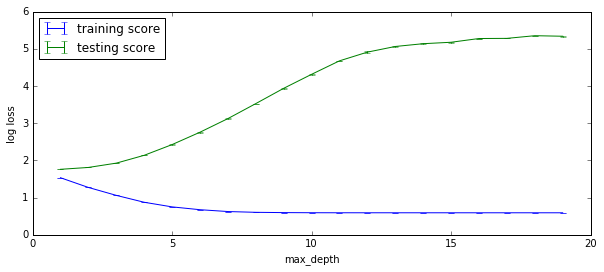

In [23]:
plot_overfit('log_loss', X_main, y_main, ensemble.GradientBoostingClassifier, {'max_depth':range(1,20)})

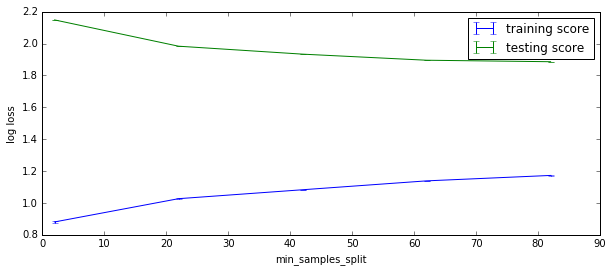

In [24]:
plot_overfit('log_loss', X_main, y_main, ensemble.GradientBoostingClassifier, {'min_samples_split':range(2,100,20)}, param_static={'max_depth':4})

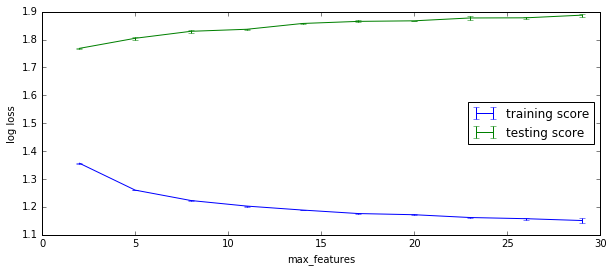

In [25]:
plot_overfit('log_loss', X_main, y_main, ensemble.GradientBoostingClassifier, {'max_features':range(2,30,3)}, param_static={'max_depth':4, 'min_samples_split':60})

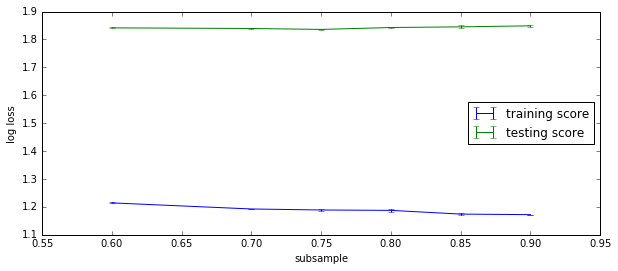

In [26]:
plot_overfit('log_loss', X_main, y_main, ensemble.GradientBoostingClassifier, {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}, param_static={'max_depth':4, 'min_samples_split':60, 'max_features':15})

* evaluate log loss score

In [27]:
model_gb = ensemble.GradientBoostingClassifier(max_depth=4, min_samples_split=60, max_features=15, subsample=0.7)

#get score
gb_score = get_cv_log(model_gb, X_main, y_main, 6)
print ('cross-validated log loss score: ', gb_score)

#get predictions
_, model_gb_pred, model_gb_pred_proba = get_predictions(model_gb, X_test, X_train, y_train)

cross-validated log loss score:  1.78099666384


* summarize scores and identify top performers. from the barplot below, we seee that the 2 best models are Random Forest and Gradient Boosted. Let's continue trying to improve the scores of the top 2 by doing feature engineering.

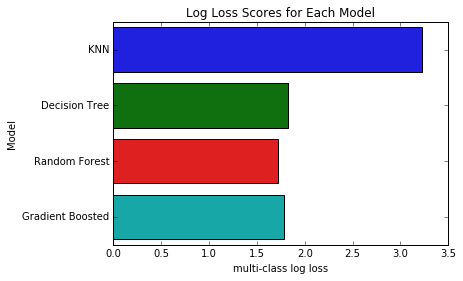

In [28]:
sns.barplot(x=[knn_score, tree_score, rf_score, gb_score], y=['KNN', 'Decision Tree', 'Random Forest', 'Gradient Boosted'])
plt.title('Log Loss Scores for Each Model')
plt.ylabel('Model')
plt.xlabel('multi-class log loss');

## Step 4: Model Improvement

#### Feature Engineering

* let's look at the most important features as considered by the Random Forest model.

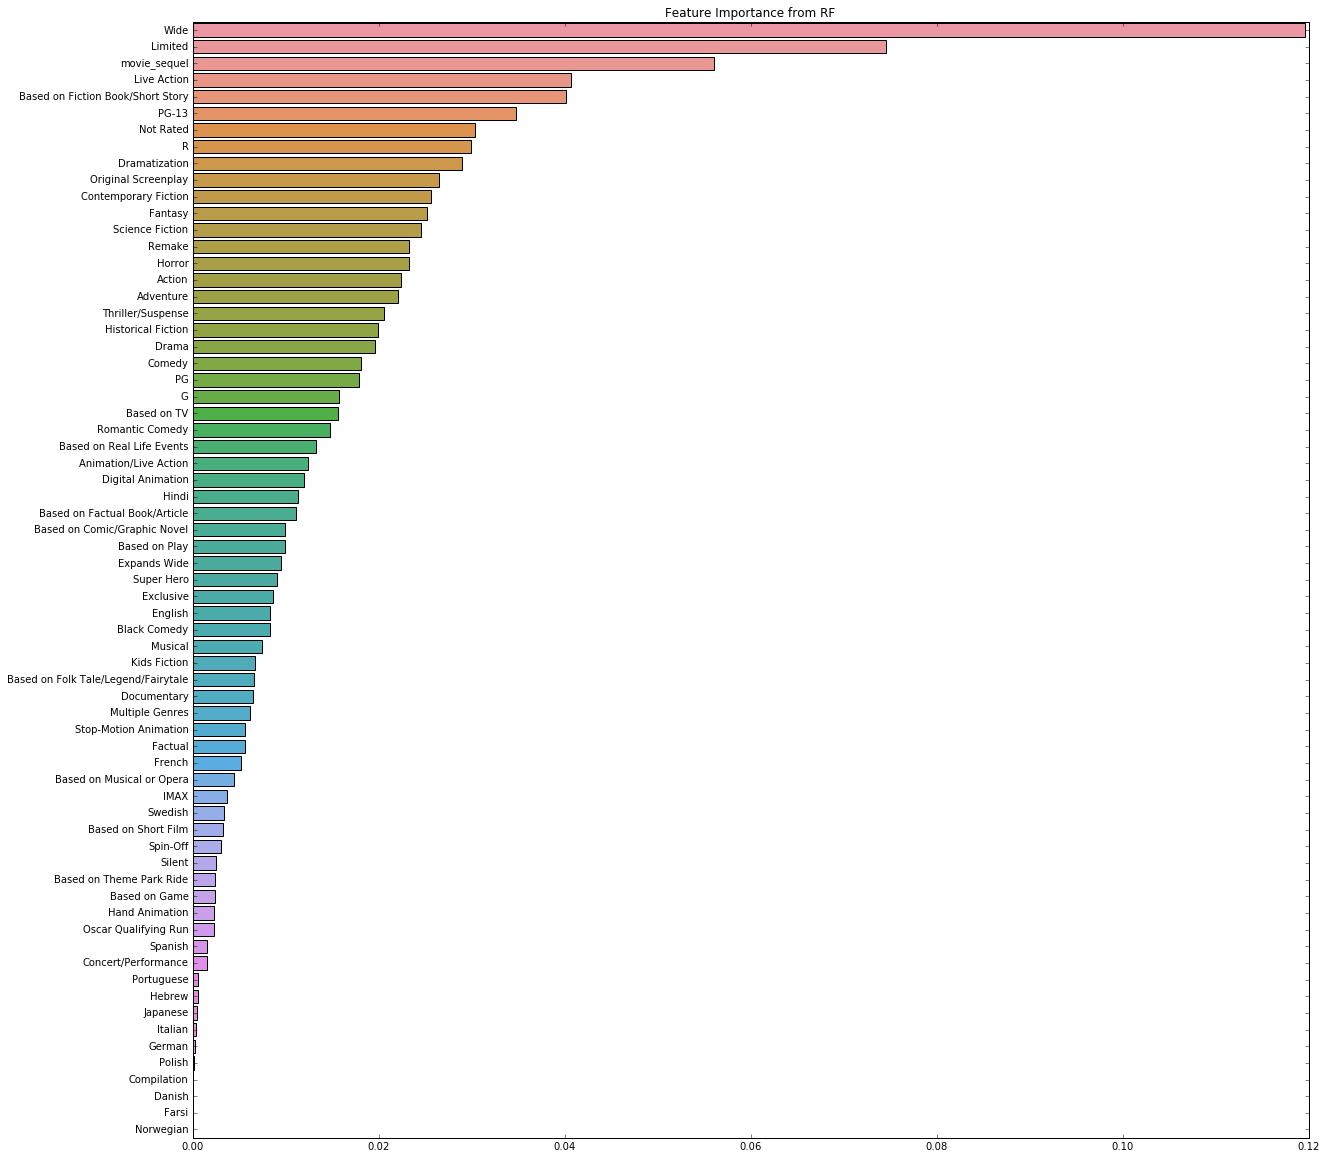

In [29]:
model_rf_improvement = ensemble.RandomForestClassifier(n_estimators=150, max_depth=13, min_samples_split=18, max_features=25)
model_rf_improvement.fit(X_train, y_train)

zipped_rf = list(zip(X_train.columns, model_rf_improvement.feature_importances_))
zipped_rf.sort(key = lambda t: t[1], reverse = True)

feature_list = []
score_list = []
for feature in zipped_rf:
    feature_list.append(feature[0])
    score_list.append(feature[1])

fig, ax = plt.subplots(1,1)
ax.set_title('Feature Importance from RF')
fig.set_size_inches(20,20)
sns.barplot(ax=ax, y=feature_list, x=score_list);  

* we see that Hindi and English are heavily used features while other languages are barely used in the forest. let's remove languages besides these 2 identified languages. 

In [30]:
y_improvement = df_main['Category']
X_improvement = df_main.drop(['Category', 'French', 'Swedish','Spanish', 'Silent','Farsi', 'German', 'Portuguese', 'Hebrew', 'Italian', 'Polish', 'Japanese', 'Danish', 'Norwegian'], axis=1)

* we saw earlier that production method had an imbalanced number of datapoints. from the forest feature importance, we also notice that besides Live Action, Digital Animation and Animation/Live Action the rest of the subcategories are not heavily used. Let's collapse these into a smaller set of sub-categories -- 1.) Live Action 2.) Animation/Live Action 3.) Animation

In [32]:
#remove all previous production categories
list_remove = df['production_method'].unique().tolist()
list_remove.remove('Multiple Production Methods')
X_improvement.drop(list_remove, axis=1, inplace=True)

#modify production method to only 3 categories 
df['production_method'] = df['production_method'].map(modify_prod_method)

#one-hot encode  new production method and add to independent features. drop one feature to avoid co-linearity
dummies = pd.get_dummies(df['production_method'])
dummies.drop('Animation/Live Action', axis=1,inplace=True)
X_improvement = pd.concat([X_improvement, dummies], axis=1)

* from the case study, it mentioned that Competition was an important feature during a movie production process. let's create features that address this defined importance. to do so, let's create features that count how many movies are competing each year under the same genre and under total for the year.

In [33]:
#competition under the same genre
df_competition = df_orig.groupby(['production_year', 'genre']).size().reset_index()
df_orig['competition_genre'] = df_orig.apply(get_num_competitors, args=(df_competition,), axis=1)
X_improvement['competition_genre'] = df_orig['competition_genre'].values

#competition of all movies produced in the same year
df_competition = df_orig.groupby('production_year').size().reset_index()
df_orig['competition_total'] = df_orig.apply(get_num_competitors_total, args=(df_competition,), axis=1)
X_improvement['competition_total'] = df_orig['competition_total'].values

* from the case study, it mentioned that 'movie board rating' was an important factor. let's see the effect on model performance by creating a ranked ordered list for 'movie board rating' based on average movie gross rather than one-hot encoding as we've done previously.

In [34]:
df_orig.groupby('movie_board_rating_display_name')['total'].mean().reset_index().sort_values('total', ascending=True)

,movie_board_rating_display_name,total
2,Not Rated,14.891566
1,NC-17,26.666667
5,R,62.256696
4,PG-13,140.764172
0,G,152.333333
3,PG,153.846154


In [35]:
#create a new category for movie board rating which is based on ranked order of total sales under each category
movie_board_rating_ranked_list = df_orig.groupby('movie_board_rating_display_name')['total'].mean().reset_index().sort_values('total', ascending=True)['movie_board_rating_display_name'].tolist()
df['movie_board_rating_ranked'] = df['movie_board_rating_display_name'].map(rating_to_ranked_order)
X_improvement['movie_board_rating_ranked'] = df['movie_board_rating_ranked'].values

#since we added a ranked category list for movie board rating, let's drop the one-hot encoded
list_remove = df['movie_board_rating_display_name'].unique().tolist()
list_remove.remove('NC-17')
X_improvement.drop(list_remove, axis=1, inplace=True)

* from the case study, it mentioned that 'genre' was an important factor. let's do the same thing we did for movie rating for 'genre'

In [36]:
df_orig.groupby('genre')['total'].mean().reset_index().sort_values('total', ascending=False)

,genre,total
1,Adventure,302.514019
0,Action,203.064516
9,Musical,143.166667
11,Thriller/Suspense,91.106870
3,Comedy,90.230769
12,Western,80.833333
7,Horror,78.675676
10,Romantic Comedy,73.750000
2,Black Comedy,54.000000
6,Drama,51.380062


In [37]:
#create ranked list for genre as defined by order total sales above
genre_ranked_list = df_orig.groupby('genre')['total'].mean().reset_index().sort_values('total', ascending=True)['genre'].tolist()
df['genre_ranked'] = df['genre'].map(genre_to_ranked_order)
X_improvement['genre_ranked'] = df['genre_ranked'].values

#remove one-hot categories
list_remove = df['genre'].unique().tolist()
list_remove.remove('Western')
X_improvement.drop(list_remove, axis=1, inplace=True)

#### Random Forest

* find best parameters

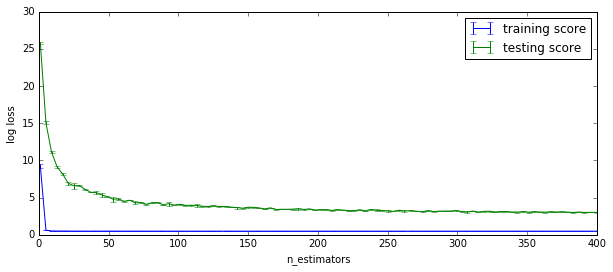

In [38]:
plot_overfit('log_loss', X_improvement, y_improvement, ensemble.RandomForestClassifier, {'n_estimators':np.linspace(1,400,100, dtype=int)})

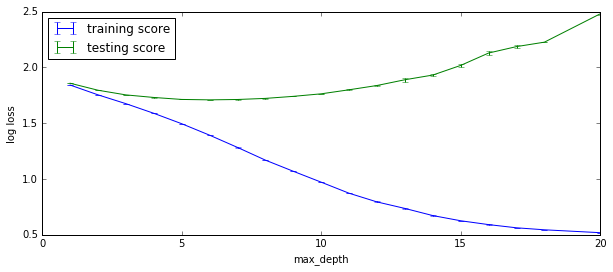

In [39]:
plot_overfit('log_loss', X_improvement, y_improvement, ensemble.RandomForestClassifier, {'max_depth':np.linspace(1,20,19, dtype=int)}, param_static={'n_estimators':280})

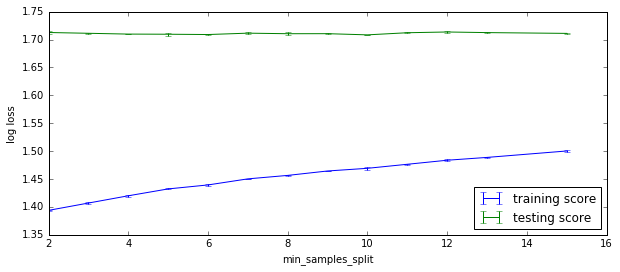

In [40]:
plot_overfit('log_loss', X_improvement, y_improvement, ensemble.RandomForestClassifier, {'min_samples_split':np.linspace(2,15,13, dtype=int)}, param_static={'n_estimators':280, 'max_depth':6})

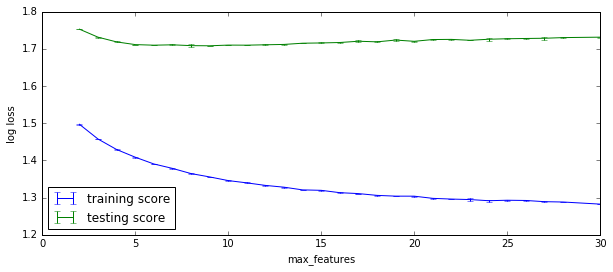

In [41]:
plot_overfit('log_loss', X_improvement, y_improvement, ensemble.RandomForestClassifier, {'max_features':np.linspace(2,30,28, dtype=int)}, param_static={'n_estimators':280, 'max_depth':6, 'min_samples_split':2})

* we can see from the log loss score below it has decreased after adding the newly created features. this improvement in log loss reflects an improvement in the probability / quality of each prediction from the model. let's go with these feature transformations for now and move on with analyzing the model in closer detail.

In [42]:
model_rf_improvement = ensemble.RandomForestClassifier(n_estimators=280, max_depth=6, min_samples_split=2, max_features=13)

#get score
rf_score_improvement = get_cv_log(model_rf_improvement, X_improvement, y_improvement, 6)
print ('cross-validated log loss score: ', rf_score_improvement)

#get predictions
X_train_improvement, X_test_improvement, y_train_improvement, y_test_improvement = model_selection.train_test_split(X_improvement, y_improvement, test_size=.3)
model_rf_improvement, model_rf_improvement_pred, model_rf_improvement_pred_proba = get_predictions(model_rf_improvement, X_test_improvement, X_train_improvement, y_train_improvement)

cross-validated log loss score:  1.69037011167


* we can see from the feature importance below, that there are features that are more used than others. this indicates that we can still perform more feature transformations on other features. for now, let's make use of this feature set and take a closer look at the model's quality of predictions.

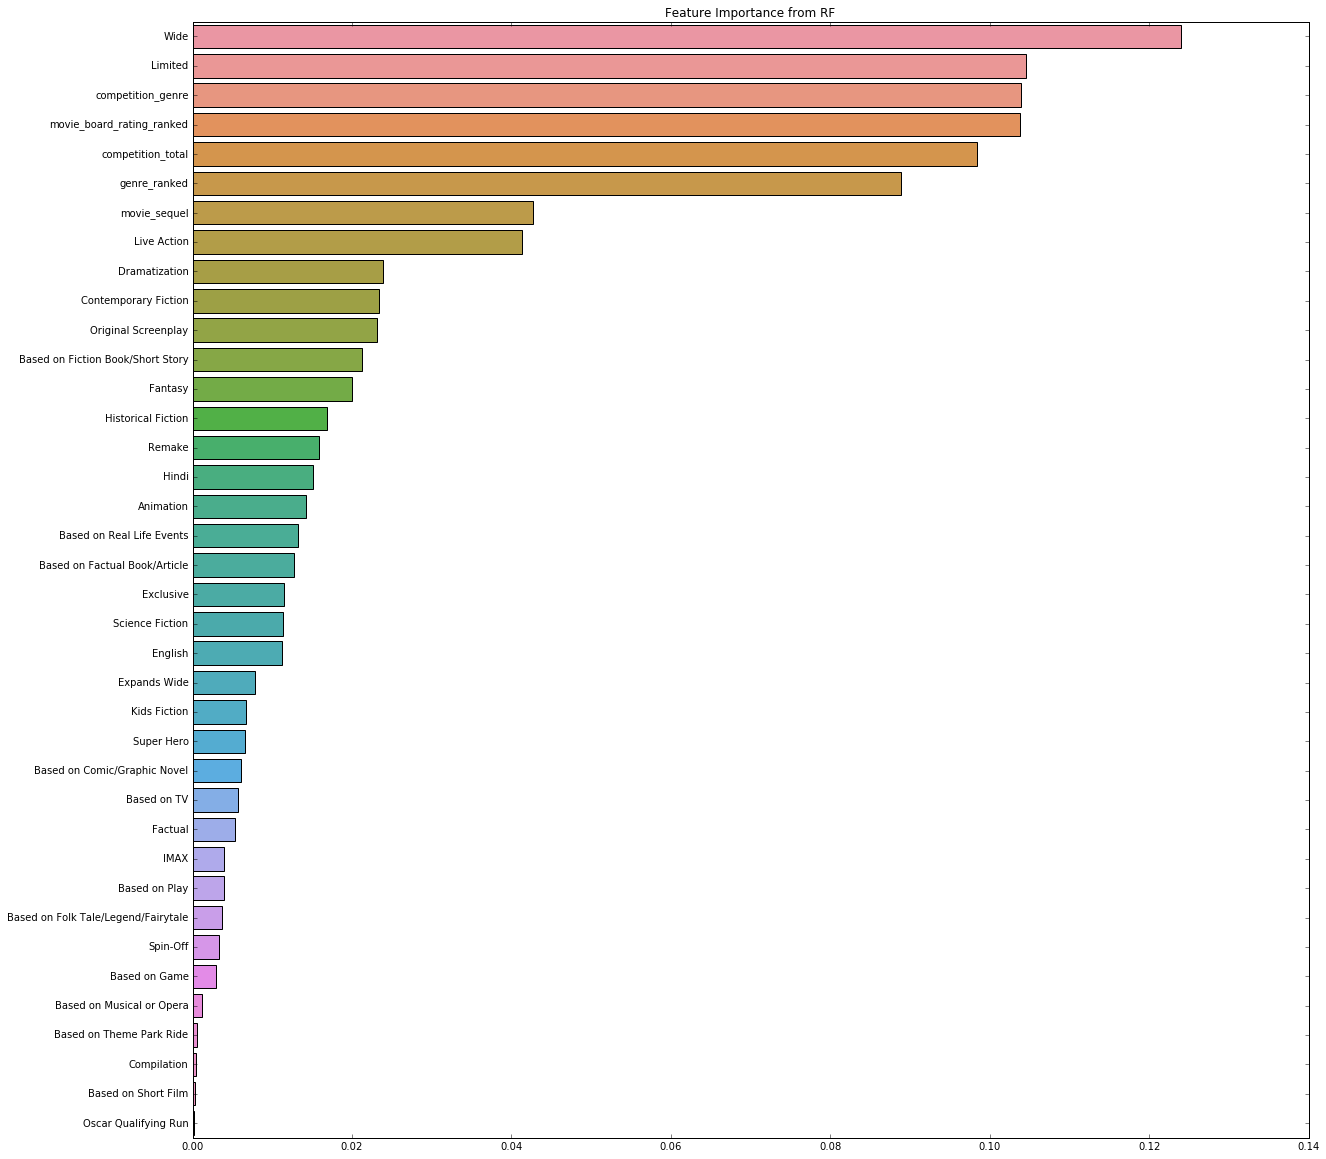

In [43]:
zipped_rf = list(zip(X_train_improvement.columns, model_rf_improvement.feature_importances_))
zipped_rf.sort(key = lambda t: t[1], reverse = True)

feature_list = []
score_list = []
for feature in zipped_rf:
    feature_list.append(feature[0])
    score_list.append(feature[1])

fig, ax = plt.subplots(1,1)
ax.set_title('Feature Importance from RF')
fig.set_size_inches(20,20)
sns.barplot(ax=ax, y=feature_list, x=score_list);  

## Step 5: Model Analysis (a closer look at Random Forest's performance)

In [44]:
model_final = ensemble.RandomForestClassifier(n_estimators=280, max_depth=6, min_samples_split=2, max_features=13)
model_final, model_rf_improvement_pred, model_rf_improvement_pred_proba = get_predictions(model_rf_improvement, X_test_improvement, X_train_improvement, y_train_improvement)

* plot confusion matrix

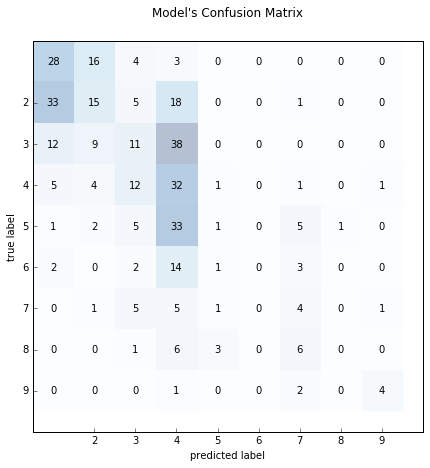

In [45]:
plot_cm(y_test_improvement, model_rf_improvement_pred)

* plot roc curve. to see roc-curve & respective auc scores of each class and the model in entirety (mirco averaged & macro averaged auc score), we must use a one vs rest method. micro averaged score gives more importance to larger classes while macro averaged score gives more weight to smaller classes. in our dataset, movies are largely imbalanced towards lower categories (1-4), so if wanting to optimize these classes, pay attention to micro averaged. if performance wants to be measured towards smaller imbalanced classes (categories 5-9), make use macro averaged.

In [46]:
#create train test split except category is one-hot
y_improvement = pd.get_dummies(df_main['Category']).values
X_train_improvement, X_test_improvement, y_train_improvement, y_test_improvement = model_selection.train_test_split(X_improvement, y_improvement, test_size=.3)

In [47]:
#use random forest encapsulated with onevsrest in order compute roc curve, precision-recall curve per-class
rf_onevsrest = multiclass.OneVsRestClassifier(ensemble.RandomForestClassifier(n_estimators=280, max_depth=6, min_samples_split=2, max_features=13))
rf_onevsrest_pred_proba = rf_onevsrest.fit(X_train_improvement, y_train_improvement).predict_proba(X_test_improvement)

In [48]:
# Compute roc curve and auc score for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_improvement.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_improvement[:, i], rf_onevsrest_pred_proba[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    
# compute micro-average roc curve and auc score
fpr["micro"], tpr["micro"], _ = metrics.roc_curve(y_test_improvement.ravel(), rf_onevsrest_pred_proba.ravel())
roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])

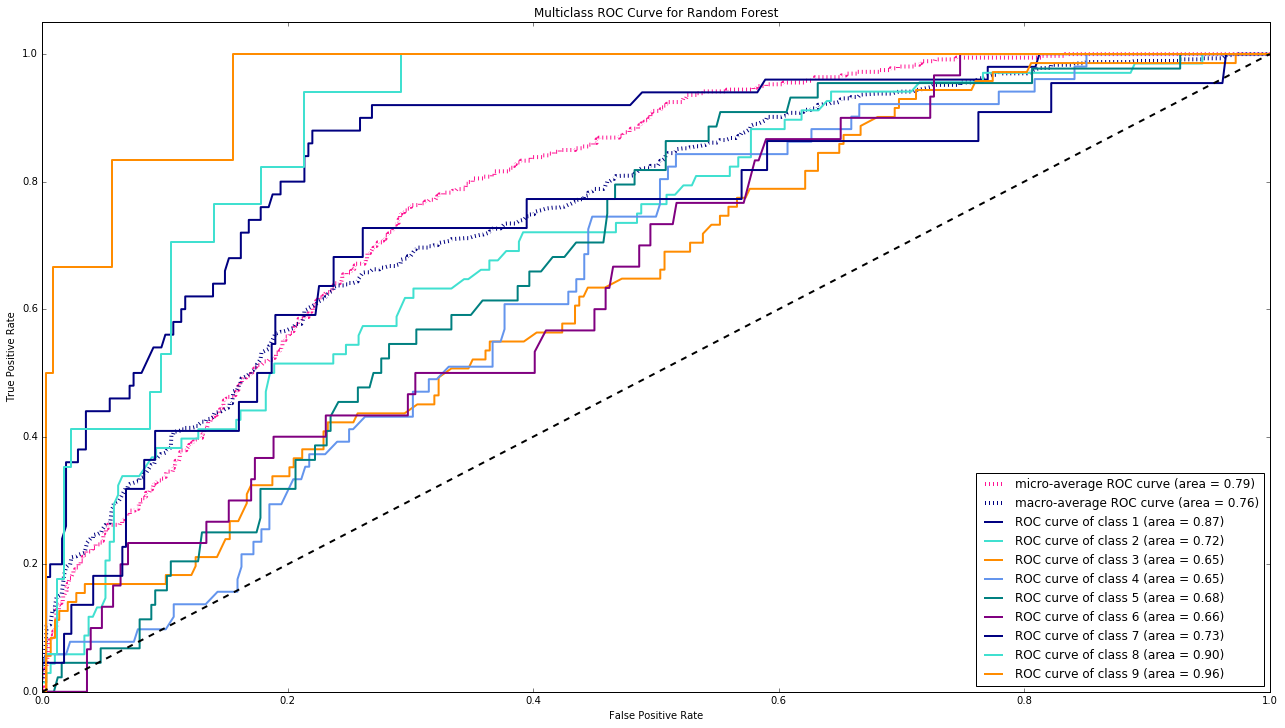

In [52]:
# let's first aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])
    
mean_tpr /= n_classes

# compute maccro-average roc curve and auc score
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# plot micro, macro, each-class roc curve
plt.figure(figsize=(22,12))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve for Random Forest')
plt.legend(loc="lower right");

* plot precision recall and per class precision recall. 

In [50]:
#compute multiclass precision recall 
precision = dict()
recall = dict()
average_precision = dict()

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'purple'])
lw = 2

#compute per class precision recall
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(y_test_improvement[:, i],rf_onevsrest_pred_proba[:, i])
    average_precision[i] = metrics.average_precision_score(y_test_improvement[:, i], rf_onevsrest_pred_proba[:, i])

# compute micro-average prec-recall curve 
precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(y_test_improvement.ravel(), rf_onevsrest_pred_proba.ravel())
average_precision["micro"] = metrics.average_precision_score(y_test_improvement, rf_onevsrest_pred_proba, average="micro")

# compute macro-average prec-recall curve
precision["macro"], recall["macro"], _ = metrics.precision_recall_curve(y_test_improvement.ravel(), rf_onevsrest_pred_proba.ravel())
average_precision["macro"] = metrics.average_precision_score(y_test_improvement, rf_onevsrest_pred_proba, average="macro")

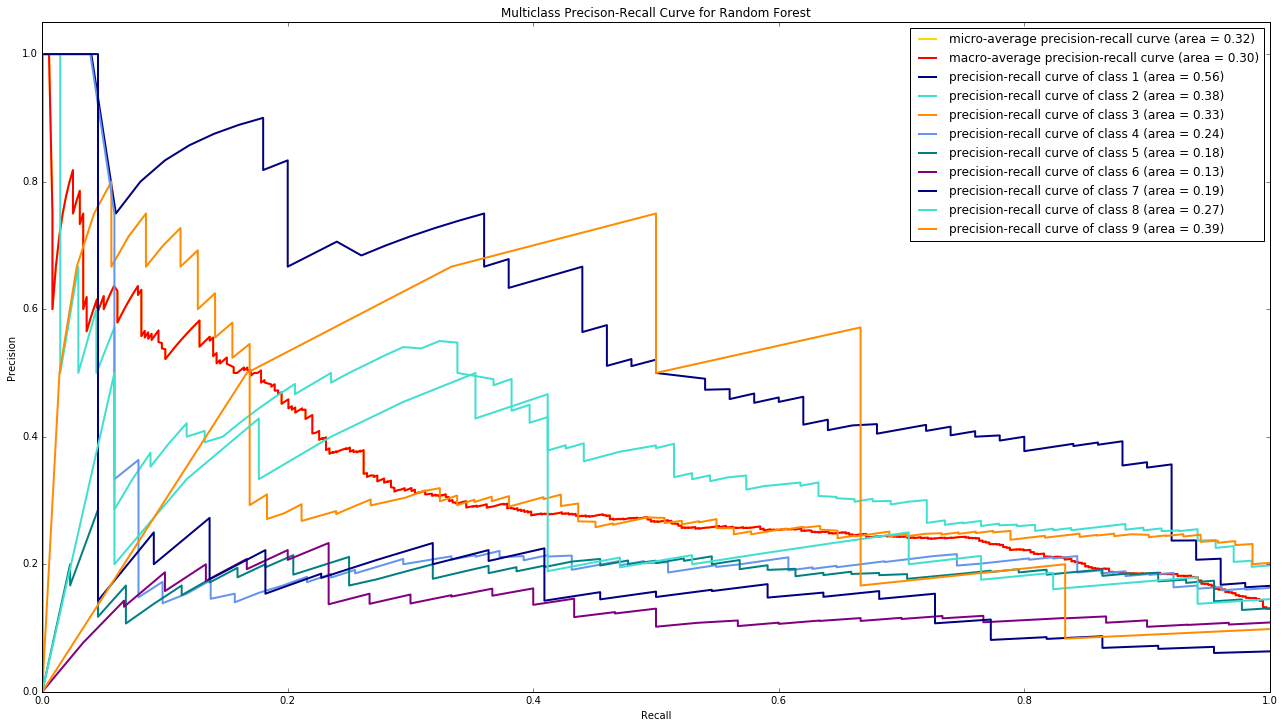

In [51]:
# plot micro, macro, each-class precision-recall
plt.figure(figsize=(22,12))
plt.plot(recall["micro"], precision["micro"], color='gold', lw=lw,
         label='micro-average precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
plt.plot(recall["macro"], precision["macro"], color='red', lw=lw,
         label='macro-average precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["macro"]))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i+1, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multiclass Precison-Recall Curve for Random Forest')
plt.legend(loc="upper right");

## Step 6: Make Predictions on Scoring Data

In [53]:
df_training = pd.read_excel('/home/ubuntu/challenge_quantiphi/training_sheet.xlsx')
df_scoring = pd.read_excel('/home/ubuntu/challenge_quantiphi/scoring_sheet.xlsx')

#this category was not present in training data, cannot be used for predictions
df_scoring.drop(['production_budget', 'board_rating_reason'], axis=1, inplace=True)

In [54]:
df_scoring = prepare_data(df_scoring)

In [66]:
for col in X_improvement.columns:
    X_scoring[col] = df_scoring[col].values

In [68]:
model_rf_improvement.predict(X_scoring)

array([7, 7, 7, 8, 9, 7, 5, 5, 5, 5, 4, 4, 7, 5, 4, 4, 5, 9, 4, 4, 5, 4, 1,
       4, 4, 5, 3, 5, 4, 4, 1, 5, 4, 4, 3, 1, 1, 4, 4, 3, 4, 3, 4, 1, 3, 1,
       1, 4, 1, 3, 1, 4, 1, 4, 3, 3, 1, 4, 3, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2])

In [73]:
np.savetxt('scoring_predictions.txt', [int(x) for x in model_rf_improvement.predict(X_scoring)], delimiter='\n')

In [75]:
preds = [int(x) for x in model_rf_improvement.predict(X_scoring)]

In [77]:
np.savetxt('scoring_predictions2.txt', preds, delimiter='\n')